This script reads in the script from the last run of `html_analysis.py`. It adds a bunch more relevant columns that will be used for regressions later.

In [49]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

Read data

In [9]:
html = pd.read_csv('../data/3_final_webpage_metadata.csv')
inFile = pd.read_csv('../data/startup_url_list.csv')

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3269: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


(Temporary) delete:

1. `Unnamed: 0` - accidentally exported to csv including index
2. `yr_from_start` - not an accurate measurement

These columns shouldn't be here next time we run analysis

In [32]:
html = html.drop(['Unnamed: 0'], axis=1)

Merge html with the infile on entityid

In [12]:
html = html.merge(inFile, on='entityid')

Define companies as failed, not-failed (exited), or unknown

In [22]:
failedStatus = ['Out of Business', 'In Bankruptcy']
exitedStatus = ['Publicly-held', 'Acquired/Merged', 'In IPO Registration']
otherStatus = ['Private & Independent', 'Assets Acquired']

If ownership status is in failed, give it a 1, if its in exitedstatus, give it a 0, if its in neither, -1

In [24]:
conditions = [
    html.ownershipstatus.isin(failedStatus),
    html.ownershipstatus.isin(exitedStatus),
    html.ownershipstatus.isin(otherStatus)
]
values = [1, 0, -1]
html['failed'] = np.select(conditions, values)

In [38]:
# Define end year of a company `end_yr`
html['end_yr'] = html['exit_date'].str.slice(start=0, stop=4) \
    .astype('float', errors='ignore') # This will have NAs
# Start yr `start_yr`
html['start_yr'] = html['startdate'].str.slice(start=0, stop=4) \
    .fillna(html['lastVC'].str.slice(start=0, stop=4)) \
    .astype('float', errors='ignore')
# Lifespan (end_yr - start_yr)
html['lifespan'] = html['end_yr'] - html['start_yr']

Fix NA values for lifespan. The problem here is that we're missing exit dates (and in turn `end_yr`) for these companies, so we have to make a prediction

This is a pretty serious problem...we're missing end years for ~80% of our companies:

In [46]:
html.groupby('entityid').first().end_yr.isna().sum() \
    / html.entityid.nunique()

0.796298643681075

How is lastVC + some time as a prediction? For companies *with* an end year, how far is that from their lastVC?

In [72]:
groups = html.groupby('entityid').first()
groups = groups.query('end_yr.isna() == False')
groups['lastVCYear'] = pd.to_datetime(groups.lastVC).dt.year
groups['endVCdiff'] = groups.end_yr - groups.lastVCYear

In [73]:
groups[groups.endVCdiff < 0].ownershipstatus.value_counts()

Acquired/Merged          204
Publicly-held             63
Private & Independent     57
Assets Acquired            9
Name: ownershipstatus, dtype: int64

0               Tesaria
1               Tesaria
2               Tesaria
3               Tesaria
4               Tesaria
              ...      
830492    Truthset Inc.
830493    Truthset Inc.
830494    Truthset Inc.
830495    Truthset Inc.
830496    Truthset Inc.
Name: entityname, Length: 830497, dtype: object

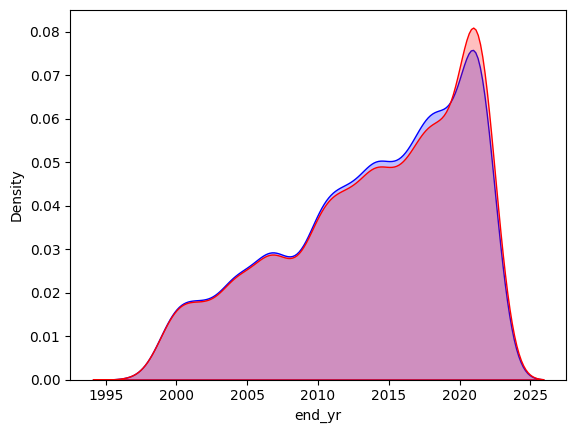

In [51]:
sns.kdeplot(groups.end_yr, color='b', fill='b');
sns.kdeplot(pd.to_datetime(groups.lastVC).dt.year, color='r', fill='b');


In [ ]:
# Convert website size to log
html['websize_log'] = np.log(html['website_size_kb']).replace([-np.inf], 0);



In [33]:
for i in html.columns:
    print(i)

entityid
yr_from_start
capture_yr
capture_m
file_path
file_exists
website_size_kb
careers
blog
login
contact
team
about
news
faq
call_to_action
testimonial
title
description
keywords
p_count
h_count
img_count
a_count
table_count
form_count
script_count
entityname
new_industrygroup
state
weburl
pb_companyid
startdate
lastVC
ownershipstatus
exit_date
failed
